### Samuel METIN , ENSIIE & UEVE (M2DS)
### Daigo TELLIER-TERAWAKI , ENSIIE

# Projet - Predictive Models (TP5)

### 1) Choix du/des modèle(s) de Machine Learning pour prédire la variable Churn

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [121]:
df = pd.read_csv("celldata.csv")
df_enc = pd.get_dummies(df, drop_first=True)

X = df_enc.drop(columns=["Churn"])
y = df_enc["Churn"]

df_enc.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn,Geography_Germany,Geography_Spain,Gender_Male
0,632,50,5,107959.39,1,1,1,6985,1,True,False,False
1,649,42,7,0.00,2,0,1,22974,0,False,False,False
2,595,29,6,150685.79,1,1,0,87771,0,False,False,True
3,653,35,6,116662.96,2,1,1,23864,0,False,True,True
4,559,40,7,144470.77,1,1,1,18918,0,False,True,False


In [122]:
print(df.shape)
print(df['Churn'].value_counts())

(8000, 11)
Churn
0    6391
1    1609
Name: count, dtype: int64


In [115]:
def evaluate(model, X, y, K, test=True, get_Gender_Male=False):
    y_true_folds = []
    y_pred_folds = []
    y_proba_folds = []
    kf = KFold(n_splits=K, shuffle=True, random_state=0)

    if get_Gender_Male: # Q2
        male_folds = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        modelfit = model.fit(X_train, y_train)
        if test:
            y_pred = model.predict(X_test)
            y_proba = modelfit.predict_proba(X_test)[:, 1]
            y_true = y_test
        else:
            y_pred = model.predict(X_train)
            y_proba = modelfit.predict_proba(X_train)[:, 1]
            y_true = y_train
        y_true_folds.append(y_true)
        y_pred_folds.append(y_pred)
        y_proba_folds.append(y_proba)
    
        if get_Gender_Male: # Q2
            male_folds.append(X_test["Gender_Male"])

    if get_Gender_Male: # Q2
        return y_true_folds, y_pred_folds, y_proba_folds, male_folds
    
    return y_true_folds, y_pred_folds, y_proba_folds

def Acc_AUC(y_true_folds, y_pred_folds, y_proba_folds):
    """
    Calcule Accuracy et AUC à partir des prédictions déjà faites pour chaque fold.
    
    y_true_folds : liste des y_test
    y_pred_folds : liste des prédictions (0/1)
    y_proba_folds : liste des probas du modèle (proba classe 1)
    """
    
    K = len(y_true_folds)
    acc_list = []
    auc_list = []

    for i in range(K):
        y_true = y_true_folds[i]
        y_pred = y_pred_folds[i]
        y_proba = y_proba_folds[i]

        acc_list.append(accuracy_score(y_true, y_pred))
        auc_list.append(roc_auc_score(y_true, y_proba))

    return acc_list, auc_list

In [ ]:
all_acc_test = []
all_acc_train = []
all_auc_test = []
all_auc_train = []

K = 5

models_names = ["Bayes", "LDA", "QDA", "LogReg", "KNN", "Tree", "RF", "ExTrees", "AB", "GB"]

models = [
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(C=1e5))]),
    Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=10))]),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=8, random_state=0),
    ExtraTreesClassifier(max_depth=6, random_state=0,bootstrap=True),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GradientBoostingClassifier(max_depth=5, random_state=0)
    ]

for model in models :
    y_true_test, y_pred_test, y_proba_test = evaluate(model, X, y, K, test=True)
    y_true_train, y_pred_train, y_proba_train = evaluate(model, X, y, K, test=False)

    acc_test, auc_test = Acc_AUC(y_true_test, y_pred_test, y_proba_test)
    acc_train, auc_train = Acc_AUC(y_true_train, y_pred_train, y_proba_train)

    all_acc_test.append(acc_test)
    all_acc_train.append(acc_train)
    all_auc_test.append(auc_test)
    all_auc_train.append(auc_train)

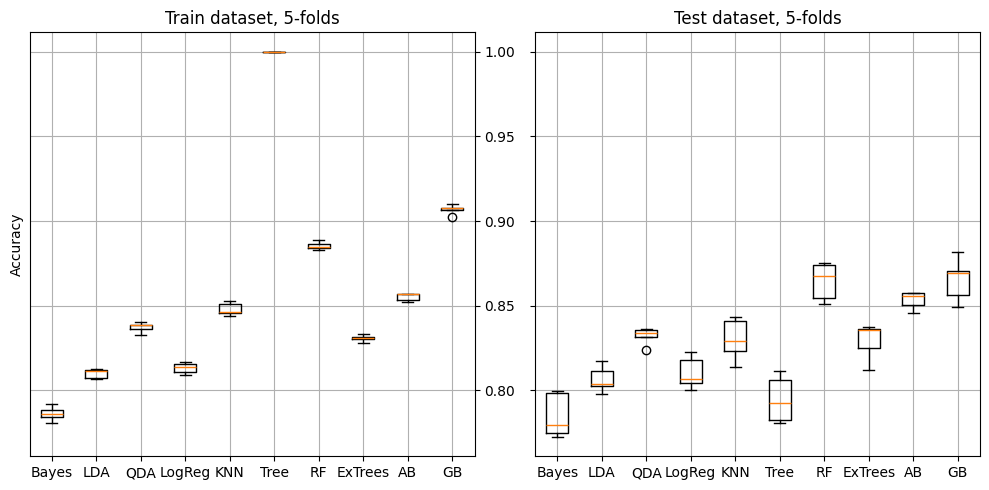

In [33]:
### Accuracy

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Train
axs[0].boxplot(all_acc_train, tick_labels=models_names)
axs[0].set_title("Train dataset, {}-folds".format(K))
axs[0].grid()
axs[0].set_ylabel("Accuracy")
axs[0].yaxis.tick_right()

# Test
axs[1].boxplot(all_acc_test, tick_labels=models_names)
axs[1].set_title("Test dataset, {}-folds".format(K))
axs[1].grid()

plt.tight_layout()

plt.show()

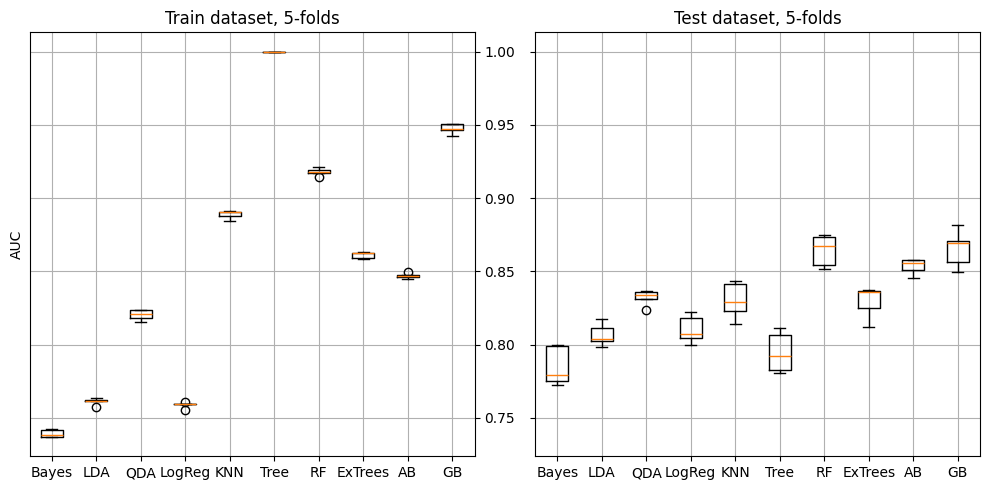

In [34]:
### AUC

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Train
axs[0].boxplot(all_auc_train, tick_labels=models_names)
axs[0].set_title("Train dataset, {}-folds".format(K))
axs[0].grid()
axs[0].set_ylabel("AUC")
axs[0].yaxis.tick_right()

# Test
axs[1].boxplot(all_acc_test, tick_labels=models_names)
axs[1].set_title("Test dataset, {}-folds".format(K))
axs[1].grid()

plt.tight_layout()

plt.show()

Ainsi, les 2 modèles qui sont les plus perfomants sur le benchmark pour la prédiction de "churn" sont le Random Forest (RF) et le Gradient Boosting (GB). En effet, en ajustant notamment la profondeur maximale des arbres, on arrive à des valeurs d'accuracy et d'AUC moyennes supérieures à 0.85 avec 5 folds sur le test. Le modèle Adaboost est aussi une variante pertinente, ce qui fait penser que la structure sous-jacente d'arbres est la plus compétitive dans ce contexte.

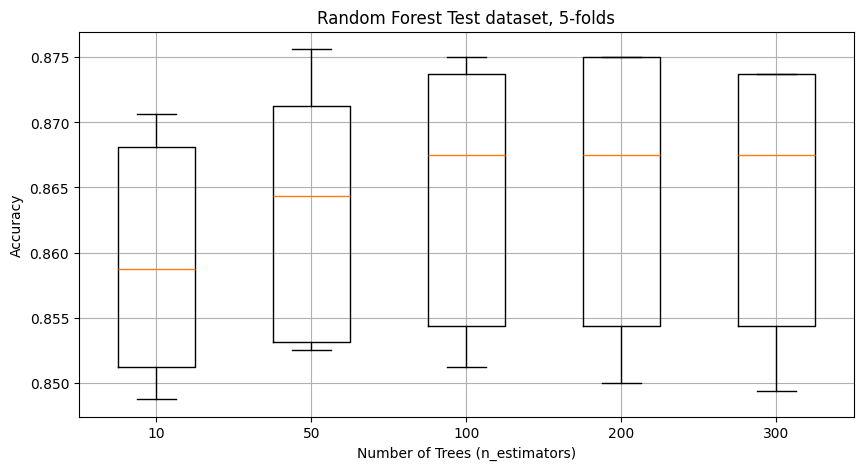

In [52]:
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=0)

n_estimators_grid = [10, 50, 100, 200, 300]

rf_acc_folds = []

for n in n_estimators_grid:
    rf_acc = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
        rf = RandomForestClassifier(max_depth=8, n_estimators=n, random_state=0)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        rf_acc.append(acc)
    rf_acc_folds.append(rf_acc)


plt.figure(figsize=(10,5))
plt.boxplot(rf_acc_folds, tick_labels=n_estimators_grid)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Test dataset, {}-folds".format(K))
plt.grid()
plt.show()

Ainsi pour le Random Forest un nombre d'arbres n_estimators=100 est suffisant, l'accuracy moyenne n'augmente pas en augmentant davantage ce paramètre.

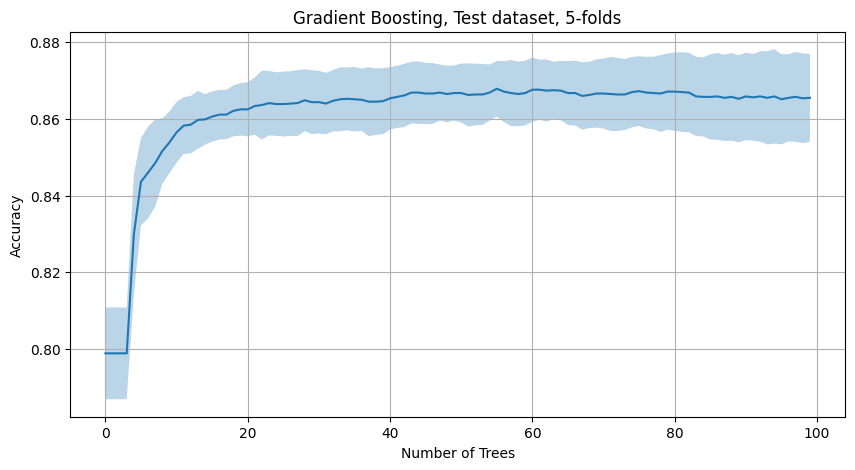

In [55]:
K = 5

kf = KFold(n_splits=K, shuffle=True, random_state=0)
GB_acc_folds = []


for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    GB = GradientBoostingClassifier(max_depth=5, random_state=0)
    GB.fit(X_train, y_train)
    GB_staged = GB.staged_predict(X_test)
    GB_acc = []

    for GB_train_predict in GB.staged_predict(X_test):
        GB_acc.append(accuracy_score(GB_train_predict, y_test))
    GB_acc_folds.append(GB_acc)


GB_acc_folds = np.array(GB_acc_folds)
GB_acc_mean = GB_acc_folds.mean(axis=0)
GB_acc_std = GB_acc_folds.std(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(GB_acc_mean)
plt.fill_between(range(len(GB_acc_mean)), GB_acc_mean - GB_acc_std,
                 GB_acc_mean + GB_acc_std, alpha=0.3, label="± 1 std")
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.title("Gradient Boosting, Test dataset, {}-folds".format(K))
plt.grid()
plt.show()

Pour le Gradient Boosting on remarque qu'un nombre proche de 25 arbres est suffisant pour atteindre l'accuracy maximale du modèle.

Conclusion :

En nous basant sur les scores d'accuracy et d'AUC sur 5-folds on a comparé 10 modèles de classification pour prédire la variable "churn". On a trouvé que les modèles les plus performants sont : un Random Forest avec 100 arbres de profondeur maximale 8 et un Gradient Boosting de 25 arbres de profondeur maximale 5. Ces deux modèles atteignent leur accuracy moyenne maximale (plus de 86%) avec des paramètres raisonnables, et ils sont donc ceux que l'on recommande.

### 2) Independance, Separation et Sufficiency pour la variable sensible Gender

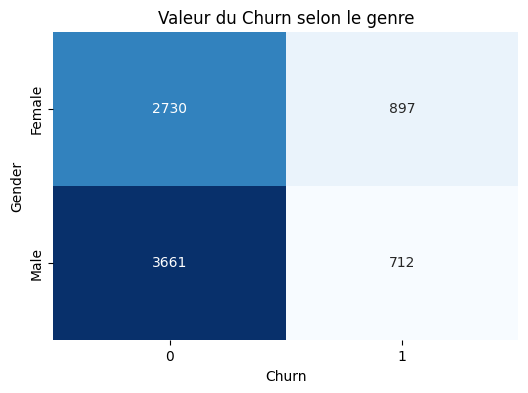

In [114]:
table = pd.crosstab(df['Gender'], df['Churn'])

plt.figure(figsize=(6,4))
sns.heatmap(table, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Valeur du Churn selon le genre")
plt.xlabel("Churn")
plt.ylabel("Gender")
plt.show()

In [89]:
# Independance
def independence_mean(y_pred_folds, male_folds):
    K = len(y_pred_folds)
    female_rates = []
    male_rates = []

    for i in range(K):
        y_pred = np.array(y_pred_folds[i])
        male = np.array(male_folds[i])

        male_rates.append(y_pred[male == True].mean())
        female_rates.append(y_pred[male == False].mean())

    return {
        "Female": np.mean(female_rates),
        "Male": np.mean(male_rates)
    }

# Separation
def separation_mean(y_true_folds, y_pred_folds, male_folds):
    K = len(y_pred_folds)

    tpr_female, fpr_female = [], []
    tpr_male, fpr_male = [], []

    for i in range(K):
        y_true = np.array(y_true_folds[i])
        y_pred = np.array(y_pred_folds[i])
        male = np.array(male_folds[i])

        # Female
        TP = ((y_pred == 1) & (y_true == 1) & (male == False)).sum()
        FN = ((y_pred == 0) & (y_true == 1) & (male == False)).sum()
        FP = ((y_pred == 1) & (y_true == 0) & (male == False)).sum()
        TN = ((y_pred == 0) & (y_true == 0) & (male == False)).sum()

        tpr_female.append(TP / (TP + FN) if TP + FN > 0 else 0)
        fpr_female.append(FP / (FP + TN) if FP + TN > 0 else 0)

        # Male
        TP = ((y_pred == 1) & (y_true == 1) & (male == True)).sum()
        FN = ((y_pred == 0) & (y_true == 1) & (male == True)).sum()
        FP = ((y_pred == 1) & (y_true == 0) & (male == True)).sum()
        TN = ((y_pred == 0) & (y_true == 0) & (male == True)).sum()

        tpr_male.append(TP / (TP + FN) if TP + FN > 0 else 0)
        fpr_male.append(FP / (FP + TN) if FP + TN > 0 else 0)

    return {
        "Female": {
            "TPR": np.mean(tpr_female),
            "FPR": np.mean(fpr_female)
        },
        "Male": {
            "TPR": np.mean(tpr_male),
            "FPR": np.mean(fpr_male)
        }
    }

# Sufficiency
def sufficiency_mean(y_true_folds, y_pred_folds, male_folds):
    K = len(y_pred_folds)

    ppv_female = []
    ppv_male = []

    for i in range(K):
        y_true = np.array(y_true_folds[i])
        y_pred = np.array(y_pred_folds[i])
        male = np.array(male_folds[i])

        # Female
        mask_female = (y_pred == 1) & (male == False)
        if mask_female.sum() > 0:
            ppv_female.append(y_true[mask_female].mean())

        # Male
        mask_male = (y_pred == 1) & (male == True)
        if mask_male.sum() > 0:
            ppv_male.append(y_true[mask_male].mean())

    return {
        "Female": np.mean(ppv_female),
        "Male": np.mean(ppv_male)
    }

i) Random Forest

In [95]:
K = 5 
rf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
y_true_folds, y_pred_folds, y_proba_folds, male_folds = evaluate(rf, X, y, K, test=True, get_Gender_Male=True)

ind_mean = independence_mean(y_pred_folds, male_folds)
sep_mean = separation_mean(y_true_folds, y_pred_folds, male_folds)
suf_mean = sufficiency_mean(y_true_folds, y_pred_folds, male_folds)

print("Independance moyenne sur 5-folds : \n P(ŷ=1 | Female) = ", round(ind_mean["Female"], 4), ", P(ŷ=1 | Male) = ", round(ind_mean["Male"], 4))
print("Separation moyenne sur 5-folds : \n TPR : P(ŷ=1 | y=1, Female) = ", round(sep_mean["Female"]["TPR"], 4), 
      ", P(ŷ=1 | y=1, Male) = ", round(sep_mean["Male"]["TPR"], 4),
      "\n FPR : P(ŷ=1 | y=0, Female) = ", round(sep_mean["Female"]["FPR"], 4),
      ", P(ŷ=1 | y=0, Male) = ", round(sep_mean["Male"]["FPR"], 4))
print("Sufficiency moyenne sur 5-folds : \n P(ŷ=1 | y=1, Female) = ", round(suf_mean["Female"], 4), 
      ", P(ŷ=1 | y=1, Male) = ", round(suf_mean["Male"], 4))

Independance moyenne sur 5-folds : 
 P(ŷ=1 | Female) =  0.1295 , P(ŷ=1 | Male) =  0.0814
Separation moyenne sur 5-folds : 
 TPR : P(ŷ=1 | y=1, Female) =  0.4365 , P(ŷ=1 | y=1, Male) =  0.3994 
 FPR : P(ŷ=1 | y=0, Female) =  0.0286 , P(ŷ=1 | y=0, Male) =  0.0199
Sufficiency moyenne sur 5-folds : 
 P(ŷ=1 | y=1, Female) =  0.8326 , P(ŷ=1 | y=1, Male) =  0.7986


ii) Gradient Boosting

In [96]:
K = 5 
gb = RandomForestClassifier(max_depth=5, n_estimators=25, random_state=0)
y_true_folds, y_pred_folds, y_proba_folds, male_folds = evaluate(gb, X, y, K, test=True, get_Gender_Male=True)

ind_mean = independence_mean(y_pred_folds, male_folds)
sep_mean = separation_mean(y_true_folds, y_pred_folds, male_folds)
suf_mean = sufficiency_mean(y_true_folds, y_pred_folds, male_folds)

print("Independance moyenne sur 5-folds : \n P(ŷ=1 | Female) = ", round(ind_mean["Female"], 4), ", P(ŷ=1 | Male) = ", round(ind_mean["Male"], 4))
print("Separation moyenne sur 5-folds : \n TPR : P(ŷ=1 | y=1, Female) = ", round(sep_mean["Female"]["TPR"], 4), 
      ", P(ŷ=1 | y=1, Male) = ", round(sep_mean["Male"]["TPR"], 4),
      "\n FPR : P(ŷ=1 | y=0, Female) = ", round(sep_mean["Female"]["FPR"], 4),
      ", P(ŷ=1 | y=0, Male) = ", round(sep_mean["Male"]["FPR"], 4))
print("Sufficiency moyenne sur 5-folds : \n P(ŷ=1 | y=1, Female) = ", round(suf_mean["Female"], 4), 
      ", P(ŷ=1 | y=1, Male) = ", round(suf_mean["Male"], 4))

Independance moyenne sur 5-folds : 
 P(ŷ=1 | Female) =  0.1003 , P(ŷ=1 | Male) =  0.055
Separation moyenne sur 5-folds : 
 TPR : P(ŷ=1 | y=1, Female) =  0.3496 , P(ŷ=1 | y=1, Male) =  0.2838 
 FPR : P(ŷ=1 | y=0, Female) =  0.0183 , P(ŷ=1 | y=0, Male) =  0.0107
Sufficiency moyenne sur 5-folds : 
 P(ŷ=1 | y=1, Female) =  0.8612 , P(ŷ=1 | y=1, Male) =  0.8372


Conclusion :

Les deux modèles ne respectent pas le critère d'Independance, car les prédictions positives du Churn pour les femmes sont significativement plus élevées que pour les hommes, ce qui était attendu vu la distribution du Churn selon le genre (biais statistique). La Separation elle n'est que partiellement respectée par Random Forest là où elle est totalement violée par le Gradient Boosting, ce qui montre que ce modèle accentue le biais sur le genre au niveau des erreurs de classification. Enfin la Sufficiency est respéctée par les deux modèles mais davantage par le Gradient Boosting, ce qui indique que les prédictions positives du churn sont plus fiables et moins biaisées entre les genres.